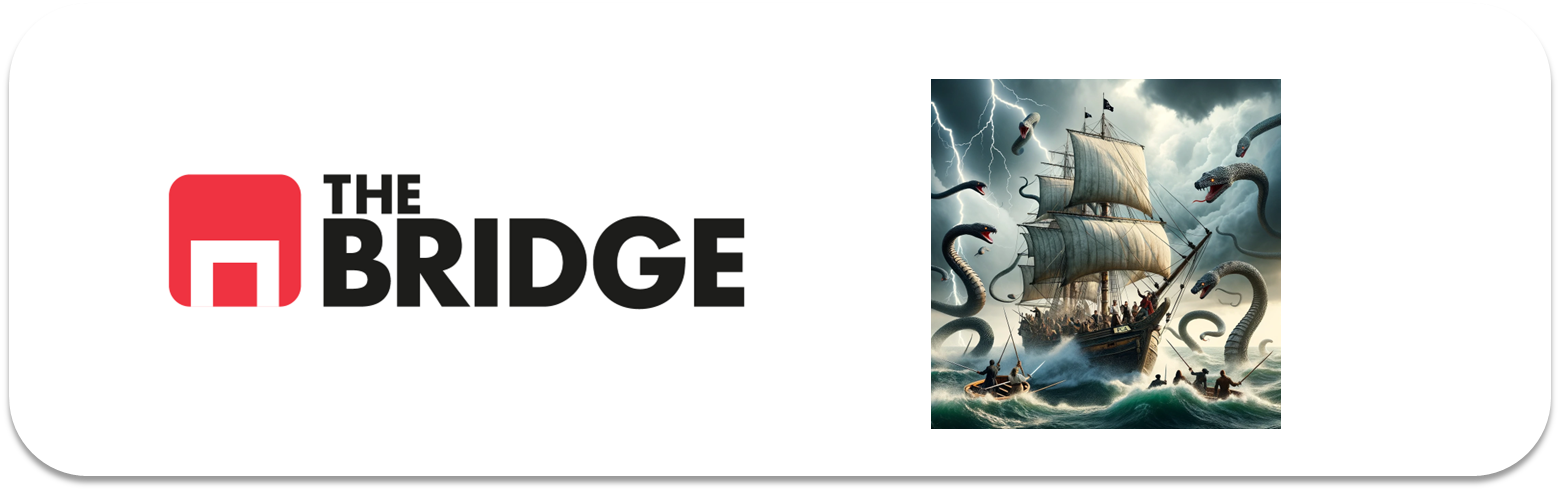

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

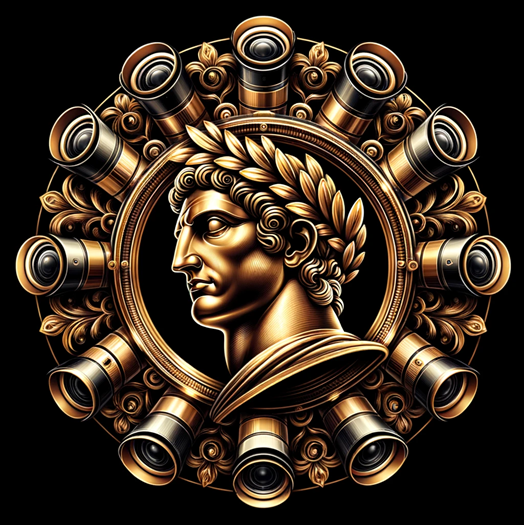

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [88]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasificación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [89]:
# Descargar el dataset
olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)

# Guardar el dataset
import pickle
with open("olivetti_faces.pkl", "wb") as f:
    pickle.dump(olivetti, f)


In [90]:
# Cargar el dataset de Olivetti Faces
X = olivetti.data  # Matriz de características (imágenes en forma de vectores)
y = olivetti.target  # Etiquetas de clase

# Construir un DataFrame con los datos
columns = [f'pixel_{i}' for i in range(X.shape[1])]
df_olivetti = pd.DataFrame(X, columns=columns)  # Agregar los píxeles como columnas
df_olivetti['target'] = y  # Agregar la columna objetivo

# Hacer un split en train y test con al menos 80 instancias en el test y estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=80, stratify=y, random_state=42)

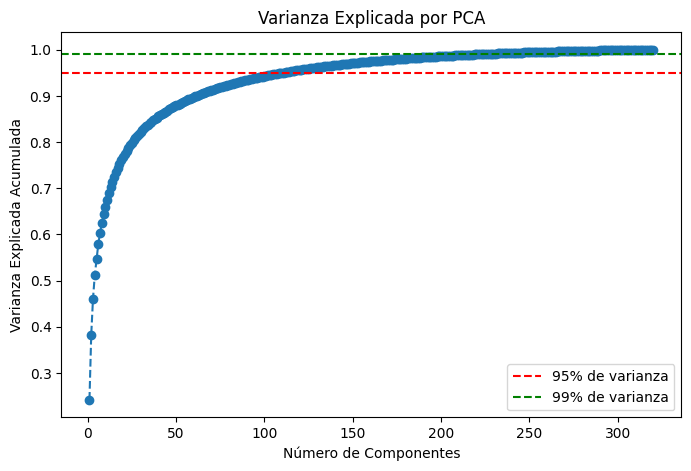

(111, 221)

In [91]:
# Aplicar PCA sin reducir la dimensionalidad (para obtener la varianza explicada)
pca_full = PCA()
pca_full.fit(X_train)

# Obtener la varianza explicada acumulada
varianza_explicada_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

# Determinar el número de componentes necesarios para explicar al menos el 95% de la varianza
num_componentes_95 = np.argmax(varianza_explicada_acumulada >= 0.95) + 1

# Determinar el número de componentes necesarios para explicar al menos el 99% de la varianza
num_componentes_99 = np.argmax(varianza_explicada_acumulada >= 0.99) + 1

# Graficar la varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(varianza_explicada_acumulada) + 1), varianza_explicada_acumulada, marker="o", linestyle="--")
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Varianza Explicada por PCA")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% de varianza")
plt.axhline(y=0.99, color="g", linestyle="--", label="99% de varianza")
plt.legend()
plt.show()

num_componentes_95, num_componentes_99


In [92]:
# Aplicar PCA con 111 componentes
pca = PCA(n_components=111)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Crear DataFrames para los datos transformados
df_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(111)])
df_train_pca['target'] = y_train

df_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(111)])
df_test_pca['target'] = y_test

In [93]:
# Modelo baseline: RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Evaluación con cross-validation de 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=cv, scoring="balanced_accuracy")

# Entrenar y evaluar en el conjunto de test
clf.fit(X_train_pca, y_train)
y_pred_test = clf.predict(X_test_pca)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)

# Guardar baseline results
baseline_results = {
    "Balanced Accuracy (Cross-Val)": np.mean(cv_scores),
    "Balanced Accuracy (Test Set)": test_balanced_acc
}

# Mostrar los resultados
print("Baseline Results:", baseline_results)


Baseline Results: {'Balanced Accuracy (Cross-Val)': 0.875, 'Balanced Accuracy (Test Set)': 0.9375}


### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [94]:
# Instanciar PCA sin especificar ni componentes ni varianza explicada
pca_micro = PCA()
pca_micro.fit(X_train)

# Modelo baseline: RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Evaluación con cross-validation de 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="balanced_accuracy")

# Entrenar y evaluar en el conjunto de test
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)

# Guardar baseline results
baseline_results = {
    "Balanced Accuracy (Cross-Val)": np.mean(cv_scores),
    "Balanced Accuracy (Test Set)": test_balanced_acc
}

# Mostrar los resultados
print("Baseline Results:", baseline_results)

Baseline Results: {'Balanced Accuracy (Cross-Val)': 0.9174999999999999, 'Balanced Accuracy (Test Set)': 0.95}


In [95]:
# Seleccionar un rango de valores para la compresión entre 0.2% y 2.5%
porcentajes_compresion = [0.2, 0.5, 1.0, 1.5, 2.5]  # Porcentajes de compresión
num_componentes = [int(X_train.shape[1] * (p / 100)) for p in porcentajes_compresion]

# Mostrar el número de componentes seleccionados
for p, n in zip(porcentajes_compresion, num_componentes):
    print(f"Para una compresión del {p}%, se seleccionan {n} componentes principales")

# Modelo baseline: RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Evaluación con cross-validation de 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="balanced_accuracy")

# Entrenar y evaluar en el conjunto de test
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
test_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)

# Guardar baseline results
baseline_results = {
    "Balanced Accuracy (Cross-Val)": np.mean(cv_scores),
    "Balanced Accuracy (Test Set)": test_balanced_acc
}

Para una compresión del 0.2%, se seleccionan 8 componentes principales
Para una compresión del 0.5%, se seleccionan 20 componentes principales
Para una compresión del 1.0%, se seleccionan 40 componentes principales
Para una compresión del 1.5%, se seleccionan 61 componentes principales
Para una compresión del 2.5%, se seleccionan 102 componentes principales


In [96]:
# Seleccionar un rango de valores para la compresión entre 0.2% y 2.5%
porcentajes_compresion = [0.2, 0.5, 1.0, 1.5, 2.5]  # Porcentajes de compresión
num_componentes = [int(X_train.shape[1] * (p / 100)) for p in porcentajes_compresion]

# Diccionario para guardar los resultados
results = {}

# Entrenar y evaluar el modelo para cada nivel de compresión
for p, n in zip(porcentajes_compresion, num_componentes):
    if n > 0:
        print(f"Entrenando modelo con {n} componentes principales (compresión del {p}%)")
        
        # Aplicar PCA con el número de componentes seleccionado
        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # Modelo baseline: RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Evaluación con cross-validation de 5 folds
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=cv, scoring="balanced_accuracy")
        
        # Entrenar y evaluar en el conjunto de test
        clf.fit(X_train_pca, y_train)
        y_pred_test = clf.predict(X_test_pca)
        test_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
        
        # Guardar resultados
        results[p] = {
            "Balanced Accuracy (Cross-Val)": np.mean(cv_scores),
            "Balanced Accuracy (Test Set)": test_balanced_acc
        }

# Mostrar los resultados
for p, res in results.items():
    print(f"Compresión {p}% -> Cross-Val: {res['Balanced Accuracy (Cross-Val)']:.4f}, Test: {res['Balanced Accuracy (Test Set)']:.4f}")

Entrenando modelo con 8 componentes principales (compresión del 0.2%)
Entrenando modelo con 20 componentes principales (compresión del 0.5%)
Entrenando modelo con 40 componentes principales (compresión del 1.0%)
Entrenando modelo con 61 componentes principales (compresión del 1.5%)
Entrenando modelo con 102 componentes principales (compresión del 2.5%)
Compresión 0.2% -> Cross-Val: 0.7700, Test: 0.8500
Compresión 0.5% -> Cross-Val: 0.8850, Test: 0.9375
Compresión 1.0% -> Cross-Val: 0.9125, Test: 0.9250
Compresión 1.5% -> Cross-Val: 0.8900, Test: 0.9250
Compresión 2.5% -> Cross-Val: 0.8775, Test: 0.9250


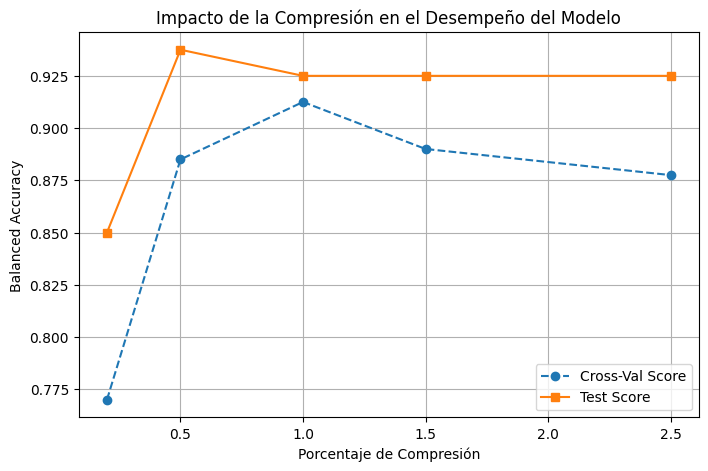

In [97]:
# Visualización gráfica de los resultados
compresion_vals = list(results.keys())
cv_scores_vals = [results[p]["Balanced Accuracy (Cross-Val)"] for p in compresion_vals]
test_scores_vals = [results[p]["Balanced Accuracy (Test Set)"] for p in compresion_vals]

plt.figure(figsize=(8,5))
plt.plot(compresion_vals, cv_scores_vals, marker='o', linestyle='--', label='Cross-Val Score')
plt.plot(compresion_vals, test_scores_vals, marker='s', linestyle='-', label='Test Score')
plt.xlabel("Porcentaje de Compresión")
plt.ylabel("Balanced Accuracy")
plt.title("Impacto de la Compresión en el Desempeño del Modelo")
plt.legend()
plt.grid()
plt.show()


In [98]:
# Valores base de comparación (modelo sin compresión)
clf_base = RandomForestClassifier(n_estimators=100, random_state=42)
cv_base = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_base = cross_val_score(clf_base, X_train, y_train, cv=cv_base, scoring="balanced_accuracy")
clf_base.fit(X_train, y_train)
y_pred_test_base = clf_base.predict(X_test)
test_balanced_acc_base = balanced_accuracy_score(y_test, y_pred_test_base)

# Diccionario para guardar los resultados
results = []

# Entrenar y evaluar el modelo para cada nivel de compresión
for p, n in zip(porcentajes_compresion, num_componentes):
    if n > 0:
        print(f"Entrenando modelo con {n} componentes principales (compresión del {p}%)")
        
        # Aplicar PCA con el número de componentes seleccionado
        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # Modelo baseline: RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Evaluación con cross-validation de 5 folds
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=cv, scoring="balanced_accuracy")
        
        # Entrenar y evaluar en el conjunto de test
        clf.fit(X_train_pca, y_train)
        y_pred_test = clf.predict(X_test_pca)
        test_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
        
        # Guardar resultados en lista de diccionarios
        results.append({
            "Num_Componentes": n,
            "Porcentaje_Compresion": p,
            "Balanced_Accuracy_CV": np.mean(cv_scores),
            "Balanced_Accuracy_Test": test_balanced_acc,
            "Diff_CV_Base": np.mean(cv_scores) - np.mean(cv_scores_base),
            "Diff_Test_Base": test_balanced_acc - test_balanced_acc_base
        })

# Convertir los resultados en DataFrame
df_results = pd.DataFrame(results)

# Mostrar el DataFrame con los resultados
print(df_results)

Entrenando modelo con 8 componentes principales (compresión del 0.2%)
Entrenando modelo con 20 componentes principales (compresión del 0.5%)
Entrenando modelo con 40 componentes principales (compresión del 1.0%)
Entrenando modelo con 61 componentes principales (compresión del 1.5%)
Entrenando modelo con 102 componentes principales (compresión del 2.5%)
   Num_Componentes  Porcentaje_Compresion  Balanced_Accuracy_CV  \
0                8                    0.2                0.7700   
1               20                    0.5                0.8975   
2               40                    1.0                0.9100   
3               61                    1.5                0.8900   
4              102                    2.5                0.8850   

   Balanced_Accuracy_Test  Diff_CV_Base  Diff_Test_Base  
0                  0.8375       -0.1475         -0.1125  
1                  0.9375       -0.0200         -0.0125  
2                  0.9375       -0.0075         -0.0125  
3         

In [99]:
# Seleccionar el mejor número de componentes según el criterio
df_filtered = df_results[(df_results["Diff_CV_Base"] >= -0.03) & (df_results["Diff_Test_Base"] >= -0.03)]
if df_filtered.empty:
    df_filtered = df_results[(df_results["Diff_CV_Base"] >= -0.05) & (df_results["Diff_Test_Base"] >= -0.05)]

best_config = df_filtered.sort_values("Porcentaje_Compresion", ascending=False).iloc[0]

# Mostrar el DataFrame con los resultados y la mejor configuración
print("\nMejor configuración seleccionada:")
print(best_config)


Mejor configuración seleccionada:
Num_Componentes           61.0000
Porcentaje_Compresion      1.5000
Balanced_Accuracy_CV       0.8900
Balanced_Accuracy_Test     0.9250
Diff_CV_Base              -0.0275
Diff_Test_Base            -0.0250
Name: 3, dtype: float64


### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [100]:
# Cargar el dataset de Olivetti Faces
olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)
X = olivetti.data  # Matriz de características (imágenes en forma de vectores)
y = olivetti.target  # Etiquetas de clase

# Construir un DataFrame con los datos
columns = [f'pixel_{i}' for i in range(X.shape[1])]
df_olivetti = pd.DataFrame(X, columns=columns)  # Agregar los píxeles como columnas
df_olivetti['target'] = y  # Agregar la columna objetivo

# Hacer un split en train y test con al menos 80 instancias en el test y estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=80, stratify=y, random_state=42)

In [101]:
# Seleccionar un rango de valores para una compresión aún mayor (entre 0.1% y 1%)
porcentajes_compresion_extrema = [0.1, 0.25, 0.5, 0.75, 1.0]  # Porcentajes de compresión extrema
num_componentes_extremos = [int(X_train.shape[1] * (p / 100)) for p in porcentajes_compresion_extrema]

# Diccionario para guardar los resultados
results_unzipped = []

# Entrenar y evaluar el modelo con reconstrucción inversa para cada nivel de compresión
for p, n in zip(porcentajes_compresion_extrema, num_componentes_extremos):
    if n > 0:
        print(f"Aplicando PCA con {n} componentes principales (compresión del {p}%)")
        
        # Aplicar PCA con el número de componentes seleccionado
        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train)
        X_train_unzipped = pca.inverse_transform(X_train_pca)  # Reconstrucción de los datos
        
        # Modelo baseline: RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Evaluación con cross-validation de 5 folds
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(clf, X_train_unzipped, y_train, cv=cv, scoring="balanced_accuracy")
        
        # Entrenar y evaluar en el conjunto de test sin aplicar PCA en X_test
        clf.fit(X_train_unzipped, y_train)
        y_pred_test = clf.predict(X_test)
        test_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
        
        # Guardar resultados en lista de diccionarios
        results_unzipped.append({
            "Num_Componentes": n,
            "Porcentaje_Compresion": p,
            "Balanced_Accuracy_CV": np.mean(cv_scores),
            "Balanced_Accuracy_Test": test_balanced_acc
        })

Aplicando PCA con 4 componentes principales (compresión del 0.1%)
Aplicando PCA con 10 componentes principales (compresión del 0.25%)
Aplicando PCA con 20 componentes principales (compresión del 0.5%)
Aplicando PCA con 30 componentes principales (compresión del 0.75%)
Aplicando PCA con 40 componentes principales (compresión del 1.0%)


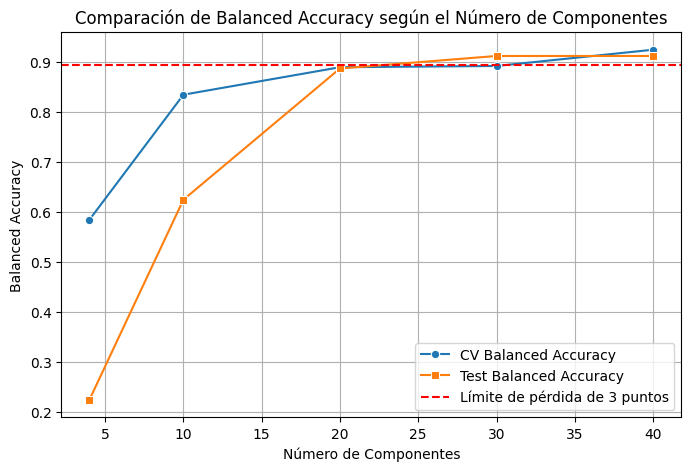

   Num_Componentes  Porcentaje_Compresion  Balanced_Accuracy_CV  \
0                4                   0.10                0.5850   
1               10                   0.25                0.8350   
2               20                   0.50                0.8900   
3               30                   0.75                0.8925   
4               40                   1.00                0.9250   

   Balanced_Accuracy_Test  
0                  0.2250  
1                  0.6250  
2                  0.8875  
3                  0.9125  
4                  0.9125  

Mejor configuración seleccionada:
Num_Componentes           40.0000
Porcentaje_Compresion      1.0000
Balanced_Accuracy_CV       0.9250
Balanced_Accuracy_Test     0.9125
Name: 4, dtype: float64


In [102]:
# Convertir los resultados en DataFrame
df_results_unzipped = pd.DataFrame(results_unzipped)

# Seleccionar el mejor número de componentes según el criterio de pérdida máxima de 3 puntos porcentuales
baseline_balanced_acc = df_results_unzipped["Balanced_Accuracy_CV"].max()  # Valor de referencia

df_filtered = df_results_unzipped[df_results_unzipped["Balanced_Accuracy_CV"] >= baseline_balanced_acc - 0.03]
if df_filtered.empty:
    df_filtered = df_results_unzipped[df_results_unzipped["Balanced_Accuracy_CV"] >= baseline_balanced_acc - 0.05]

best_pca_config = df_filtered.sort_values("Porcentaje_Compresion", ascending=False).iloc[0]

# Visualización de la comparación entre número de componentes y balanced accuracy
plt.figure(figsize=(8,5))
sns.lineplot(data=df_results_unzipped, x="Num_Componentes", y="Balanced_Accuracy_CV", marker='o', label='CV Balanced Accuracy')
sns.lineplot(data=df_results_unzipped, x="Num_Componentes", y="Balanced_Accuracy_Test", marker='s', label='Test Balanced Accuracy')
plt.axhline(y=baseline_balanced_acc - 0.03, color='r', linestyle='--', label='Límite de pérdida de 3 puntos')
plt.xlabel("Número de Componentes")
plt.ylabel("Balanced Accuracy")
plt.title("Comparación de Balanced Accuracy según el Número de Componentes")
plt.legend()
plt.grid()
plt.show()

# Mostrar el DataFrame con los resultados y la mejor configuración
print(df_results_unzipped)
print("\nMejor configuración seleccionada:")
print(best_pca_config)

### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

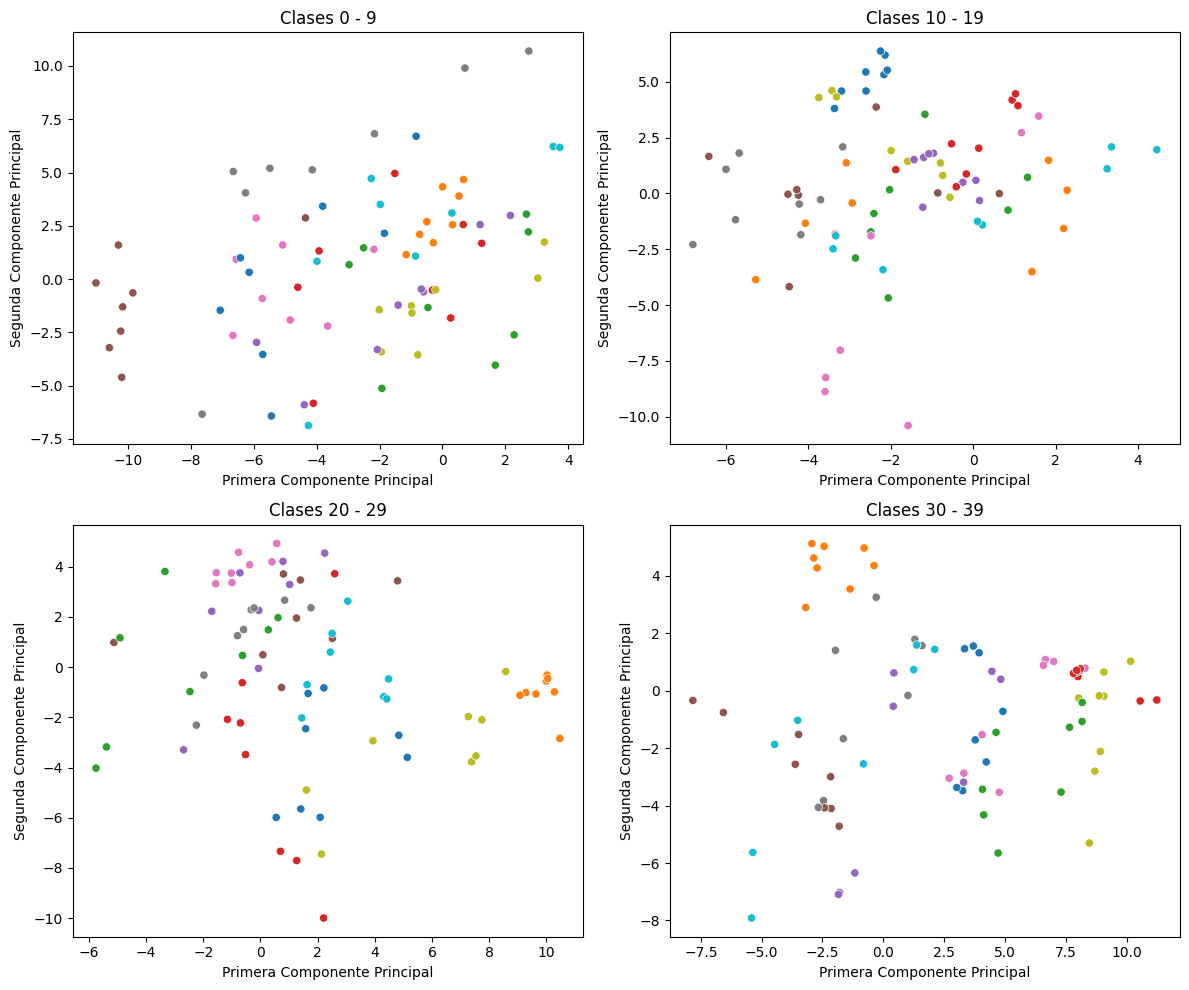

In [103]:
# Aplicar PCA con la mejor configuración seleccionada
pca = PCA(n_components=int(best_pca_config["Num_Componentes"]))
X_train_pca = pca.fit_transform(X_train)

# Convertir en DataFrame para visualización
df_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(int(best_pca_config["Num_Componentes"]))])
df_pca['target'] = y_train

# Visualización de las dos primeras componentes principales en cuatro gráficos
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    class_range = range(i * 10, (i + 1) * 10)
    subset = df_pca[df_pca['target'].isin(class_range)]
    sns.scatterplot(x='PC1', y='PC2', hue='target', palette='tab10', data=subset, ax=ax, legend=False)
    ax.set_title(f'Clases {class_range.start} - {class_range.stop-1}')
    ax.set_xlabel('Primera Componente Principal')
    ax.set_ylabel('Segunda Componente Principal')

plt.tight_layout()
plt.show()

Visualización con 10 componentes principales:


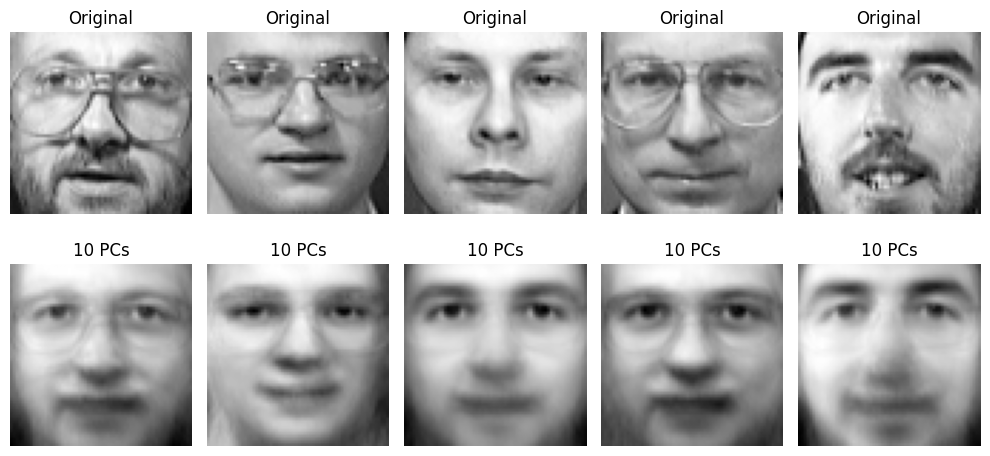

Visualización con 50 componentes principales:


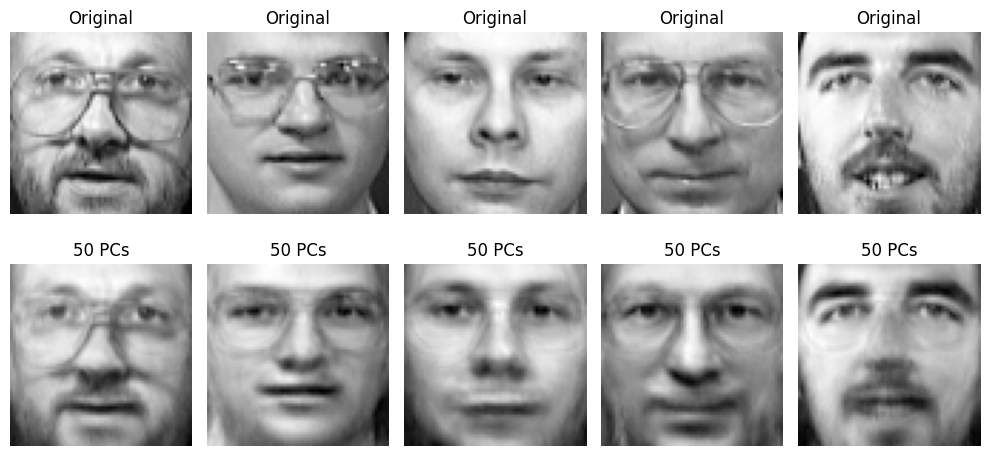

Visualización con 40 componentes principales:


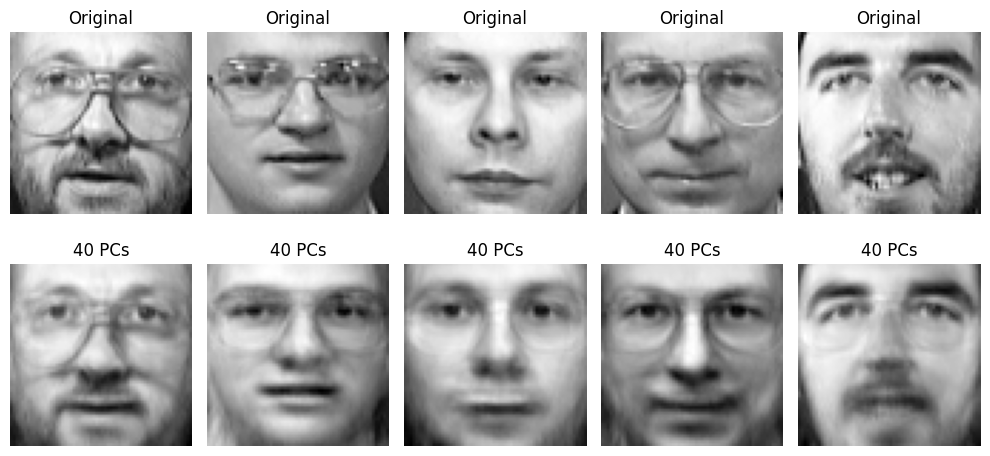

Visualización con 150 componentes principales:


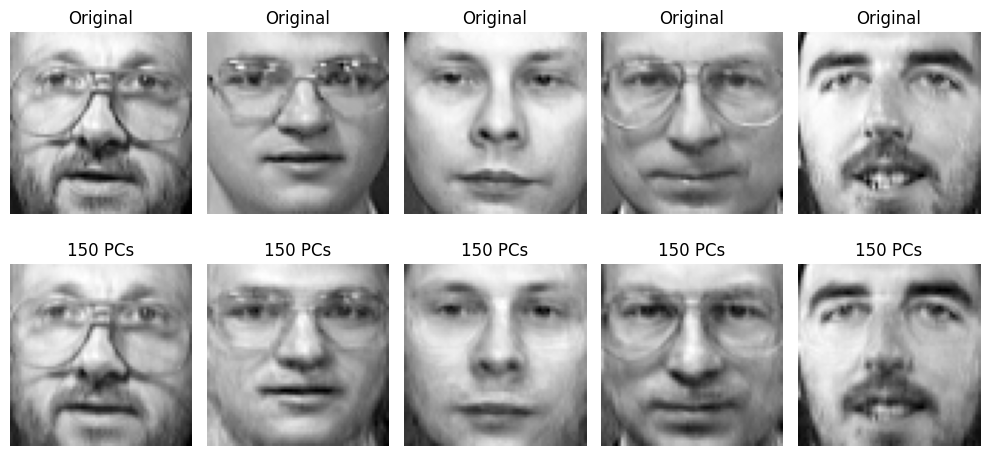

Visualización con 300 componentes principales:


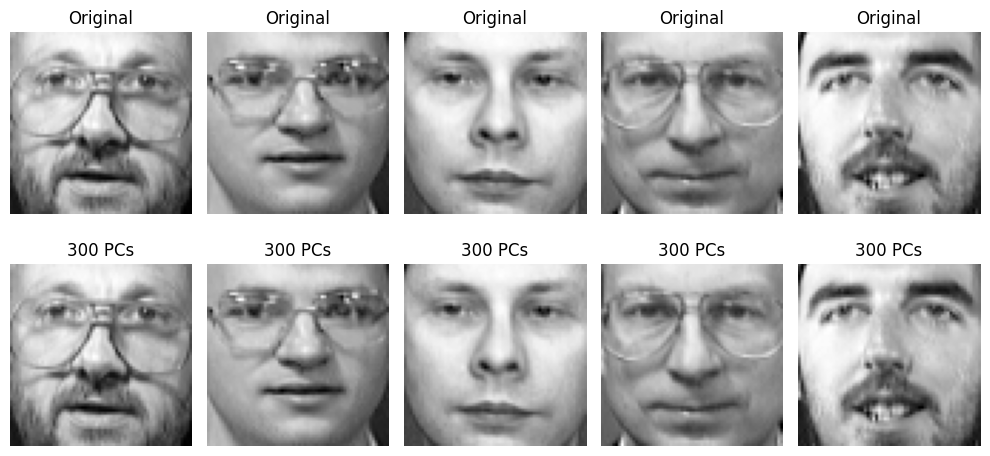

In [104]:
# Función para visualizar la reconstrucción de caras con diferentes números de PCA
def visualizar_reconstruccion(X_original, num_componentes):
    pca = PCA(n_components=num_componentes)
    X_pca = pca.fit_transform(X_original)
    X_reconstructed = pca.inverse_transform(X_pca)
    
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i in range(5):
        # Imagen original
        ax = axes[0, i]
        ax.imshow(X_original[i].reshape(64, 64), cmap='gray')
        ax.set_title("Original")
        ax.axis("off")
        
        # Imagen reconstruida
        ax = axes[1, i]
        ax.imshow(X_reconstructed[i].reshape(64, 64), cmap='gray')
        ax.set_title(f"{num_componentes} PCs")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Probar la reconstrucción con diferentes números de componentes
num_componentes_prueba = [10, 50, int(best_pca_config["Num_Componentes"]), 150, 300]
for n in num_componentes_prueba:
    print(f"Visualización con {n} componentes principales:")
    visualizar_reconstruccion(X_train, n)